In [9]:
# Experiment 3 KD with a smaller model as student

In [3]:
# Split the training data into validation set and training set use a stratified k fold 
import numpy as np
import pandas as pd
import sklearn

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler, QuantileTransformer 

from sklearn.model_selection import StratifiedKFold, KFold

In [4]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
# Knowledge distillation 
# Modified from source: https://keras.io/examples/vision/knowledge_distillation/

import Distiller

In [6]:
# Load the saved dataset
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html
california_housing_data_train = pd.read_csv('Data/california_housing_train.txt')
california_housing_data_test = pd.read_csv('Data/california_housing_test.txt')

# This dataset have strong outliers due to the hard limit of the housing price
# remove those from the training set
california_housing_data_train = california_housing_data_train[california_housing_data_train['MedHouseVal'] < 5]  


In [7]:
# Set up the datasets
x_train = california_housing_data_train.iloc[:,0:7].to_numpy()
y_train = california_housing_data_train.iloc[:,-1].to_numpy()

x_test = california_housing_data_test.iloc[:,0:7].to_numpy()
y_test = california_housing_data_test.iloc[:,-1].to_numpy()

In [8]:
# Build the student model

def buildStudentModel():
    model = models.Sequential()    
    model.add(layers.Dense(64, activation='relu'))
        
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))    
    
    return model

In [9]:
# Construct/load models

teacher_model = tf.keras.models.load_model('MlpTeacherModel/MlpTeacherModel')

# Perform the 10 fold cross validation
number_of_folds = 10

skf = KFold(n_splits=number_of_folds)

In [10]:
# Haperparameter used in the experiment
number_of_epochs = 100

train_val_results_with_distillation = []
train_val_results_without_distillation = []

test_results_with_distillation = []
test_results_without_distillation = []

for i, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):
    print(f"Fold {i}")
    
    studnet_model = buildStudentModel()
    studnet_model_without_distillation = keras.models.clone_model(studnet_model)
    
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
    distiller.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=['mse', 'mae', 'mape'],
        student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
        distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
        alpha=0.1,
        temperature=10        
    )
    # Distill teacher to student
    history = distiller.fit(
        x_train_fold, 
        y_train_fold, 
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_with_distillation.append(history.history)
    
    # Train and evaluate the student model without distillation
    studnet_model_without_distillation.compile(
        optimizer=keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=['mse', 'mae', 'mape'],
    )

    # Train and evaluate student trained from scratch.
    history = studnet_model_without_distillation.fit(
        x_train_fold, 
        y_train_fold,
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_without_distillation.append(history.history)
    
print('Training done')

Fold 0
Epoch 1/100
443/443 [==============================] - 2s 2ms/step - mse: 715.5497 - mae: 5.2339 - mape: 343.8920 - student_loss: 5.2158 - distillation_loss: 712.3611 - val_mse: 5.6242 - val_mae: 0.8357 - val_mape: 70.2367 - val_student_loss: 1.1885
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 3.9289 - mae: 0.9950 - mape: 69.2250 - student_loss: 0.9942 - distillation_loss: 3.3893 - val_mse: 1.1073 - val_mae: 0.7701 - val_mape: 50.0899 - val_student_loss: 1.0337
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 1.4838 - mae: 0.8631 - mape: 60.1420 - student_loss: 0.8646 - distillation_loss: 1.0563 - val_mse: 1.0382 - val_mae: 0.7714 - val_mape: 63.2606 - val_student_loss: 0.9557
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9218 - mae: 0.7247 - mape: 50.2411 - student_loss: 0.7239 - distillation_loss: 0.4684 - val_mse: 0.6639 - val_mae: 0.6256 - val_mape: 43.6346 - val_student_loss: 0.8011
Epoch 5/

443/443 [==============================] - 1s 3ms/step - mse: 1.2535 - mae: 0.7528 - mape: 49.2274 - student_loss: 0.7525 - distillation_loss: 0.8065 - val_mse: 0.6369 - val_mae: 0.5505 - val_mape: 33.3316 - val_student_loss: 0.6149
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9383 - mae: 0.6608 - mape: 43.0038 - student_loss: 0.6613 - distillation_loss: 0.5358 - val_mse: 4.6779 - val_mae: 1.7226 - val_mape: 130.3793 - val_student_loss: 1.5228
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 2.3889 - mae: 0.9696 - mape: 62.9747 - student_loss: 0.9706 - distillation_loss: 1.9555 - val_mse: 20.6708 - val_mae: 3.5338 - val_mape: 257.1336 - val_student_loss: 2.5808
Epoch 37/100
443/443 [==============================] - 1s 3ms/step - mse: 1.4256 - mae: 0.8070 - mape: 52.5561 - student_loss: 0.8087 - distillation_loss: 1.0146 - val_mse: 0.6608 - val_mae: 0.5779 - val_mape: 29.9957 - val_student_loss: 0.6725
Epoch 38/100
443/443 [====

443/443 [==============================] - 1s 2ms/step - mse: 0.6284 - mae: 0.5868 - mape: 37.9389 - student_loss: 0.5880 - distillation_loss: 0.2104 - val_mse: 0.4791 - val_mae: 0.5270 - val_mape: 34.3512 - val_student_loss: 0.5888
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0454 - mae: 0.6817 - mape: 44.1539 - student_loss: 0.6806 - distillation_loss: 0.6425 - val_mse: 0.5224 - val_mae: 0.5751 - val_mape: 41.4158 - val_student_loss: 0.6860
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1346 - mae: 0.6824 - mape: 44.3066 - student_loss: 0.6818 - distillation_loss: 0.7096 - val_mse: 0.4874 - val_mae: 0.5438 - val_mape: 37.3482 - val_student_loss: 0.6351
Epoch 70/100
443/443 [==============================] - 1s 3ms/step - mse: 0.6694 - mae: 0.5929 - mape: 38.5175 - student_loss: 0.5927 - distillation_loss: 0.2557 - val_mse: 0.5173 - val_mae: 0.5309 - val_mape: 31.0999 - val_student_loss: 0.6140
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4823 - mae: 0.5244 - mape: 33.7094 - student_loss: 0.5248 - distillation_loss: 0.0837 - val_mse: 0.4060 - val_mae: 0.4827 - val_mape: 31.4579 - val_student_loss: 0.6199
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 4.2259 - mse: 470.7118 - mae: 4.2259 - mape: 287.2283 - val_loss: 3.1496 - val_mse: 18.2658 - val_mae: 3.1496 - val_mape: 241.9051
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.5976 - mse: 7.3969 - mae: 1.5976 - mape: 106.7085 - val_loss: 1.3167 - val_mse: 4.6906 - val_mae: 1.3167 - val_mape: 74.2466
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.3627 - mse: 5.6828 - mae: 1.3627 - mape: 90.0391 - val_loss: 1.1841 - val_mse: 3.0685 - val_mae: 1.1841 - val_mape: 96.2587
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0425 - mse: 2.8406 - mae: 1.0425 - mape: 68.1691 - val_loss: 0.8058 - val_mse: 1.

443/443 [==============================] - 1s 2ms/step - loss: 0.5807 - mse: 0.6668 - mae: 0.5807 - mape: 35.7699 - val_loss: 0.5512 - val_mse: 0.5767 - val_mae: 0.5512 - val_mape: 28.7754
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5767 - mse: 0.6151 - mae: 0.5767 - mape: 35.3495 - val_loss: 0.5438 - val_mse: 0.6516 - val_mae: 0.5438 - val_mape: 31.2018
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5702 - mse: 0.6800 - mae: 0.5702 - mape: 35.0817 - val_loss: 0.6056 - val_mse: 0.6636 - val_mae: 0.6056 - val_mape: 32.5713
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5746 - mse: 0.6730 - mae: 0.5746 - mape: 35.1598 - val_loss: 0.5063 - val_mse: 0.4736 - val_mae: 0.5063 - val_mape: 29.3640
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5832 - mse: 0.6381 - mae: 0.5832 - mape: 36.0056 - val_loss: 0.5112 - val_mse: 0.4387 - val_mae: 0.5112 - val_mape: 33.9210
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4874 - mse: 0.4354 - mae: 0.4874 - mape: 29.5302 - val_loss: 0.4671 - val_mse: 0.3824 - val_mae: 0.4671 - val_mape: 29.8655
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4900 - mse: 0.4413 - mae: 0.4900 - mape: 29.8328 - val_loss: 0.4645 - val_mse: 0.3912 - val_mae: 0.4645 - val_mape: 28.3115
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4960 - mse: 0.4477 - mae: 0.4960 - mape: 30.3078 - val_loss: 0.6018 - val_mse: 0.5644 - val_mae: 0.6018 - val_mape: 44.7141
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4949 - mse: 0.4453 - mae: 0.4949 - mape: 30.1713 - val_loss: 0.4843 - val_mse: 0.4394 - val_mae: 0.4843 - val_mape: 27.2241
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5001 - mse: 0.4533 - mae: 0.5001 - mape: 30.4616 - val_loss: 0.4740 - val_mse: 0.4191 - val_mae: 0.4740 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 1.2834 - mae: 0.7991 - mape: 52.2554 - student_loss: 0.7977 - distillation_loss: 0.8649 - val_mse: 0.8971 - val_mae: 0.7504 - val_mape: 55.5602 - val_student_loss: 0.7846
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8123 - mae: 0.6717 - mape: 44.0168 - student_loss: 0.6729 - distillation_loss: 0.3854 - val_mse: 1.6678 - val_mae: 0.9974 - val_mape: 74.5492 - val_student_loss: 1.0391
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 20.6379 - mae: 1.6661 - mape: 110.1993 - student_loss: 1.6622 - distillation_loss: 20.0732 - val_mse: 0.5562 - val_mae: 0.5890 - val_mape: 40.5003 - val_student_loss: 0.5175
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9313 - mae: 0.6905 - mape: 45.4934 - student_loss: 0.6930 - distillation_loss: 0.5095 - val_mse: 3.0604 - val_mae: 1.4221 - val_mape: 108.1040 - val_student_loss: 1.6329
Epoch 22/100

443/443 [==============================] - 1s 2ms/step - mse: 0.5896 - mae: 0.5875 - mape: 38.2996 - student_loss: 0.5901 - distillation_loss: 0.1755 - val_mse: 0.9460 - val_mae: 0.7514 - val_mape: 54.5586 - val_student_loss: 0.7027
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3469 - mae: 0.7818 - mape: 50.8007 - student_loss: 0.7805 - distillation_loss: 0.9275 - val_mse: 23.1340 - val_mae: 3.3029 - val_mape: 228.5959 - val_student_loss: 2.7898
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 6.0625 - mae: 1.2211 - mape: 80.6740 - student_loss: 1.2177 - distillation_loss: 5.6308 - val_mse: 0.5986 - val_mae: 0.5713 - val_mape: 32.1189 - val_student_loss: 0.3819
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5608 - mae: 0.5675 - mape: 37.0353 - student_loss: 0.5673 - distillation_loss: 0.1494 - val_mse: 0.5419 - val_mae: 0.5484 - val_mape: 32.1161 - val_student_loss: 0.3658
Epoch 55/100
443/443 [=====

443/443 [==============================] - 1s 2ms/step - mse: 0.6070 - mae: 0.5892 - mape: 38.1625 - student_loss: 0.5901 - distillation_loss: 0.1936 - val_mse: 0.4864 - val_mae: 0.5247 - val_mape: 31.9235 - val_student_loss: 0.3459
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 2.3451 - mae: 0.8713 - mape: 56.4292 - student_loss: 0.8705 - distillation_loss: 1.9203 - val_mse: 0.4869 - val_mae: 0.5237 - val_mape: 31.5016 - val_student_loss: 0.3819
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5217 - mae: 0.5472 - mape: 35.5532 - student_loss: 0.5465 - distillation_loss: 0.1114 - val_mse: 0.4901 - val_mae: 0.5462 - val_mape: 36.6013 - val_student_loss: 0.4342
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 1.6254 - mae: 0.7844 - mape: 50.9504 - student_loss: 0.7827 - distillation_loss: 1.2127 - val_mse: 0.4790 - val_mae: 0.5281 - val_mape: 33.2811 - val_student_loss: 0.4115
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7926 - mse: 1.2182 - mae: 0.7926 - mape: 50.3228 - val_loss: 0.6627 - val_mse: 0.8839 - val_mae: 0.6627 - val_mape: 44.8522
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7872 - mse: 1.2694 - mae: 0.7872 - mape: 50.3647 - val_loss: 1.2203 - val_mse: 2.9817 - val_mae: 1.2203 - val_mape: 67.1023
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8121 - mse: 1.3097 - mae: 0.8121 - mape: 51.9229 - val_loss: 0.8067 - val_mse: 1.0851 - val_mae: 0.8067 - val_mape: 59.4749
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8043 - mse: 1.3236 - mae: 0.8043 - mape: 51.4854 - val_loss: 1.0342 - val_mse: 1.8894 - val_mae: 1.0342 - val_mape: 76.0129
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8496 - mse: 1.4594 - mae: 0.8496 - mape: 54.3498 - val_loss: 1.9454 - val_mse: 6.6692 - val_mae: 1.9454 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.5837 - mse: 0.6522 - mae: 0.5837 - mape: 36.1773 - val_loss: 0.7361 - val_mse: 1.0247 - val_mae: 0.7361 - val_mape: 38.6790
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6242 - mse: 0.7221 - mae: 0.6242 - mape: 39.2684 - val_loss: 0.7287 - val_mse: 0.9438 - val_mae: 0.7287 - val_mape: 52.6533
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6182 - mse: 0.7780 - mae: 0.6182 - mape: 38.9044 - val_loss: 0.5264 - val_mse: 0.4803 - val_mae: 0.5264 - val_mape: 34.9639
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5894 - mse: 0.6715 - mae: 0.5894 - mape: 36.6555 - val_loss: 0.5133 - val_mse: 0.4770 - val_mae: 0.5133 - val_mape: 32.8325
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6100 - mse: 0.7351 - mae: 0.6100 - mape: 37.9035 - val_loss: 0.5008 - val_mse: 0.4528 - val_mae: 0.5008 - val_mape: 31.0834
Epo

443/443 [==============================] - 1s 2ms/step - mse: 32.6958 - mae: 2.5631 - mape: 174.5862 - student_loss: 2.5559 - distillation_loss: 32.2331 - val_mse: 1.2500 - val_mae: 0.8291 - val_mape: 51.2600 - val_student_loss: 0.6223
Epoch 2/100
443/443 [==============================] - 1s 3ms/step - mse: 18.6459 - mae: 2.2647 - mape: 149.5660 - student_loss: 2.2588 - distillation_loss: 18.1984 - val_mse: 0.8295 - val_mae: 0.7434 - val_mape: 57.5226 - val_student_loss: 0.6224
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 10.1143 - mae: 1.5607 - mape: 104.7324 - student_loss: 1.5571 - distillation_loss: 9.6182 - val_mse: 0.6415 - val_mae: 0.6350 - val_mape: 45.9029 - val_student_loss: 0.5608
Epoch 4/100
443/443 [==============================] - 1s 3ms/step - mse: 321.3263 - mae: 4.7344 - mape: 312.1838 - student_loss: 4.7180 - distillation_loss: 319.7329 - val_mse: 0.6287 - val_mae: 0.6176 - val_mape: 43.5077 - val_student_loss: 0.5180
Epoch 5/100
443/443

443/443 [==============================] - 1s 3ms/step - mse: 2.1113 - mae: 0.9621 - mape: 63.5362 - student_loss: 0.9594 - distillation_loss: 1.6785 - val_mse: 0.5995 - val_mae: 0.6176 - val_mape: 44.9397 - val_student_loss: 0.5007
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9826 - mae: 0.7023 - mape: 45.9983 - student_loss: 0.7007 - distillation_loss: 0.5512 - val_mse: 0.5466 - val_mae: 0.5862 - val_mape: 41.8487 - val_student_loss: 0.5188
Epoch 36/100
443/443 [==============================] - 1s 3ms/step - mse: 1.1508 - mae: 0.7465 - mape: 48.5598 - student_loss: 0.7457 - distillation_loss: 0.7097 - val_mse: 1.3035 - val_mae: 0.8602 - val_mape: 43.9229 - val_student_loss: 0.6522
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 5.6973 - mae: 1.3076 - mape: 85.9280 - student_loss: 1.3035 - distillation_loss: 5.1898 - val_mse: 0.5411 - val_mae: 0.5778 - val_mape: 40.9085 - val_student_loss: 0.5360
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9269 - mae: 0.6633 - mape: 42.8423 - student_loss: 0.6624 - distillation_loss: 0.5288 - val_mse: 0.4306 - val_mae: 0.4839 - val_mape: 30.5883 - val_student_loss: 0.4188
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4389 - mae: 0.5000 - mape: 32.3885 - student_loss: 0.4995 - distillation_loss: 0.0421 - val_mse: 0.4245 - val_mae: 0.4938 - val_mape: 32.9193 - val_student_loss: 0.4459
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5177 - mae: 0.5393 - mape: 34.7912 - student_loss: 0.5391 - distillation_loss: 0.1203 - val_mse: 0.4297 - val_mae: 0.4967 - val_mape: 32.8475 - val_student_loss: 0.4774
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 12.5020 - mae: 1.2028 - mape: 78.7638 - student_loss: 1.1992 - distillation_loss: 12.0521 - val_mse: 0.4881 - val_mae: 0.5237 - val_mape: 34.0249 - val_student_loss: 0.4064
Epoch 71/100
443/443 [=====

443/443 [==============================] - 1s 2ms/step - mse: 0.6743 - mae: 0.5503 - mape: 35.5169 - student_loss: 0.5503 - distillation_loss: 0.2803 - val_mse: 0.4239 - val_mae: 0.4804 - val_mape: 30.5575 - val_student_loss: 0.4619
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 5.9203 - mse: 613.6043 - mae: 5.9203 - mape: 390.9531 - val_loss: 0.9522 - val_mse: 1.3348 - val_mae: 0.9522 - val_mape: 74.0987
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 2.0309 - mse: 9.8877 - mae: 2.0309 - mape: 134.2732 - val_loss: 5.8547 - val_mse: 50.1640 - val_mae: 5.8547 - val_mape: 412.5654
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 2.2779 - mse: 13.1036 - mae: 2.2779 - mape: 151.4920 - val_loss: 5.7740 - val_mse: 50.9134 - val_mae: 5.7740 - val_mape: 374.6103
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 2.2746 - mse: 13.5450 - mae: 2.2746 - mape: 149.8642 - val_loss: 3.0161 - val_m

443/443 [==============================] - 1s 2ms/step - loss: 0.9385 - mse: 1.8401 - mae: 0.9385 - mape: 60.4273 - val_loss: 1.0318 - val_mse: 1.5437 - val_mae: 1.0318 - val_mape: 79.1514
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9981 - mse: 2.1067 - mae: 0.9981 - mape: 64.3264 - val_loss: 0.8983 - val_mse: 1.2053 - val_mae: 0.8983 - val_mape: 67.6894
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1693 - mse: 3.4181 - mae: 1.1693 - mape: 77.3434 - val_loss: 1.3047 - val_mse: 2.8092 - val_mae: 1.3047 - val_mape: 75.5307
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7917 - mse: 1.2462 - mae: 0.7917 - mape: 50.2317 - val_loss: 0.6373 - val_mse: 0.7618 - val_mae: 0.6373 - val_mape: 32.1820
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8381 - mse: 1.4681 - mae: 0.8381 - mape: 53.6684 - val_loss: 0.6364 - val_mse: 0.7496 - val_mae: 0.6364 - val_mape: 33.3435
Epo

443/443 [==============================] - 1s 2ms/step - loss: 0.7138 - mse: 1.2281 - mae: 0.7138 - mape: 44.9502 - val_loss: 0.7561 - val_mse: 0.9045 - val_mae: 0.7561 - val_mape: 55.5220
Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6293 - mse: 0.8516 - mae: 0.6293 - mape: 39.2062 - val_loss: 1.0540 - val_mse: 1.7302 - val_mae: 1.0540 - val_mape: 56.9682
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7456 - mse: 1.1016 - mae: 0.7456 - mape: 47.1374 - val_loss: 0.7098 - val_mse: 0.7973 - val_mae: 0.7098 - val_mape: 53.7409
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6692 - mse: 0.9212 - mae: 0.6692 - mape: 42.0851 - val_loss: 1.1798 - val_mse: 2.1845 - val_mae: 1.1798 - val_mape: 90.4528
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6168 - mse: 0.7990 - mae: 0.6168 - mape: 38.8141 - val_loss: 0.4814 - val_mse: 0.4497 - val_mae: 0.4814 - val_mape: 29.3099
Epo

Epoch 17/100
443/443 [==============================] - 1s 3ms/step - mse: 0.6190 - mae: 0.5873 - mape: 38.4527 - student_loss: 0.5866 - distillation_loss: 0.1952 - val_mse: 0.5192 - val_mae: 0.5467 - val_mape: 35.8132 - val_student_loss: 0.3226
Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7810 - mae: 0.6095 - mape: 39.9058 - student_loss: 0.6164 - distillation_loss: 0.3958 - val_mse: 0.5950 - val_mae: 0.5634 - val_mape: 34.2639 - val_student_loss: 0.2500
Epoch 19/100
443/443 [==============================] - 1s 3ms/step - mse: 0.6630 - mae: 0.5989 - mape: 38.8570 - student_loss: 0.5988 - distillation_loss: 0.2410 - val_mse: 0.5148 - val_mae: 0.5600 - val_mape: 38.6021 - val_student_loss: 0.4032
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6014 - mae: 0.5889 - mape: 38.2750 - student_loss: 0.5881 - distillation_loss: 0.1842 - val_mse: 0.5533 - val_mae: 0.5953 - val_mape: 42.1619 - val_student_loss: 0.4634
Epoch 21/100
443

443/443 [==============================] - 1s 2ms/step - mse: 2.3422 - mae: 0.6900 - mape: 43.9532 - student_loss: 0.7021 - distillation_loss: 2.0107 - val_mse: 8.9170 - val_mae: 2.1096 - val_mape: 155.8719 - val_student_loss: 1.5396
Epoch 51/100
443/443 [==============================] - 1s 3ms/step - mse: 2.5000 - mae: 0.8299 - mape: 56.6808 - student_loss: 0.8295 - distillation_loss: 2.0543 - val_mse: 0.6161 - val_mae: 0.6418 - val_mape: 48.9094 - val_student_loss: 0.5128
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5630 - mae: 0.5818 - mape: 39.1323 - student_loss: 0.5816 - distillation_loss: 0.1388 - val_mse: 0.5312 - val_mae: 0.5560 - val_mape: 37.3135 - val_student_loss: 0.3561
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5489 - mae: 0.5675 - mape: 37.3521 - student_loss: 0.5671 - distillation_loss: 0.1293 - val_mse: 0.5268 - val_mae: 0.5387 - val_mape: 34.2700 - val_student_loss: 0.2873
Epoch 54/100
443/443 [======

443/443 [==============================] - 1s 2ms/step - mse: 0.4264 - mae: 0.4919 - mape: 31.8380 - student_loss: 0.4926 - distillation_loss: 0.0336 - val_mse: 0.5013 - val_mae: 0.5609 - val_mape: 40.5854 - val_student_loss: 0.4315
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5271 - mae: 0.5444 - mape: 35.7272 - student_loss: 0.5437 - distillation_loss: 0.1191 - val_mse: 0.4361 - val_mae: 0.4972 - val_mape: 33.5616 - val_student_loss: 0.2885
Epoch 85/100
443/443 [==============================] - 1s 3ms/step - mse: 0.4145 - mae: 0.4836 - mape: 31.1718 - student_loss: 0.4832 - distillation_loss: 0.0234 - val_mse: 0.4328 - val_mae: 0.4855 - val_mape: 31.6530 - val_student_loss: 0.2540
Epoch 86/100
443/443 [==============================] - 1s 3ms/step - mse: 0.4110 - mae: 0.4813 - mape: 31.0618 - student_loss: 0.4819 - distillation_loss: 0.0202 - val_mse: 0.4312 - val_mae: 0.4901 - val_mape: 32.8192 - val_student_loss: 0.2741
Epoch 87/100
443/443 [=======

Epoch 20/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9046 - mse: 1.8424 - mae: 0.9046 - mape: 57.8831 - val_loss: 0.7126 - val_mse: 0.8024 - val_mae: 0.7126 - val_mape: 52.7629
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0143 - mse: 2.3711 - mae: 1.0143 - mape: 65.4311 - val_loss: 0.5743 - val_mse: 0.6556 - val_mae: 0.5743 - val_mape: 33.7379
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8541 - mse: 1.4582 - mae: 0.8541 - mape: 54.3831 - val_loss: 1.1911 - val_mse: 2.4192 - val_mae: 1.1911 - val_mape: 67.9986
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9031 - mse: 1.6817 - mae: 0.9031 - mape: 57.6082 - val_loss: 0.5270 - val_mse: 0.5209 - val_mae: 0.5270 - val_mape: 32.6509
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8406 - mse: 1.5165 - mae: 0.8406 - mape: 53.5351 - val_loss: 0.9746 - val_mse: 1.4785 - val_mae: 0.9746 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.5881 - mse: 0.6637 - mae: 0.5881 - mape: 36.3525 - val_loss: 0.9913 - val_mse: 1.6743 - val_mae: 0.9913 - val_mape: 56.8659
Epoch 61/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5861 - mse: 0.6497 - mae: 0.5861 - mape: 36.5496 - val_loss: 0.6237 - val_mse: 0.6515 - val_mae: 0.6237 - val_mape: 44.5336
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5960 - mse: 0.6886 - mae: 0.5960 - mape: 37.1147 - val_loss: 0.5126 - val_mse: 0.4974 - val_mae: 0.5126 - val_mape: 33.2830
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6267 - mse: 0.7543 - mae: 0.6267 - mape: 39.2955 - val_loss: 0.8048 - val_mse: 1.0877 - val_mae: 0.8048 - val_mape: 60.5490
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5782 - mse: 0.6167 - mae: 0.5782 - mape: 36.0745 - val_loss: 0.7368 - val_mse: 0.9101 - val_mae: 0.7368 - val_mape: 54.0768
Epo

Fold 4
Epoch 1/100
443/443 [==============================] - 1s 3ms/step - mse: 13.1806 - mae: 1.5371 - mape: 102.3729 - student_loss: 1.5387 - distillation_loss: 12.6869 - val_mse: 0.7031 - val_mae: 0.6428 - val_mape: 41.0645 - val_student_loss: 0.6161
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 9.0868 - mae: 1.4167 - mape: 94.4648 - student_loss: 1.4139 - distillation_loss: 8.6064 - val_mse: 0.8367 - val_mae: 0.7455 - val_mape: 56.5337 - val_student_loss: 0.4233
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 7.1257 - mae: 1.3582 - mape: 89.9913 - student_loss: 1.3556 - distillation_loss: 6.6563 - val_mse: 3.9363 - val_mae: 1.5496 - val_mape: 117.2840 - val_student_loss: 0.8438
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 5.5203 - mae: 1.1102 - mape: 73.8289 - student_loss: 1.1096 - distillation_loss: 5.0741 - val_mse: 0.5896 - val_mae: 0.5771 - val_mape: 33.9864 - val_student_loss: 0.5019
Epoch 5/1

443/443 [==============================] - 1s 2ms/step - mse: 1.4758 - mae: 0.8027 - mape: 52.5241 - student_loss: 0.8009 - distillation_loss: 1.0478 - val_mse: 0.5120 - val_mae: 0.5334 - val_mape: 31.4173 - val_student_loss: 0.5439
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 4.2848 - mae: 1.0769 - mape: 71.1711 - student_loss: 1.0775 - distillation_loss: 3.8468 - val_mse: 2.2841 - val_mae: 1.2267 - val_mape: 92.0468 - val_student_loss: 0.6449
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 12.9429 - mae: 1.6479 - mape: 108.8363 - student_loss: 1.6420 - distillation_loss: 12.4813 - val_mse: 0.4998 - val_mae: 0.5416 - val_mape: 35.2672 - val_student_loss: 0.4932
Epoch 37/100
443/443 [==============================] - 1s 3ms/step - mse: 0.5302 - mae: 0.5548 - mape: 36.3397 - student_loss: 0.5548 - distillation_loss: 0.1078 - val_mse: 0.5750 - val_mae: 0.5643 - val_mape: 31.4813 - val_student_loss: 0.5577
Epoch 38/100
443/443 [====

443/443 [==============================] - 1s 3ms/step - mse: 0.5821 - mae: 0.5708 - mape: 37.0625 - student_loss: 0.5706 - distillation_loss: 0.1663 - val_mse: 0.4915 - val_mae: 0.5230 - val_mape: 31.3219 - val_student_loss: 0.5348
Epoch 68/100
443/443 [==============================] - 1s 3ms/step - mse: 0.8537 - mae: 0.6398 - mape: 41.5104 - student_loss: 0.6393 - distillation_loss: 0.4365 - val_mse: 0.4991 - val_mae: 0.5563 - val_mape: 38.1885 - val_student_loss: 0.4155
Epoch 69/100
443/443 [==============================] - 1s 3ms/step - mse: 0.8214 - mae: 0.6407 - mape: 41.6156 - student_loss: 0.6417 - distillation_loss: 0.4096 - val_mse: 0.6471 - val_mae: 0.5980 - val_mape: 33.0519 - val_student_loss: 0.5525
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5976 - mae: 0.5838 - mape: 37.7330 - student_loss: 0.5849 - distillation_loss: 0.1786 - val_mse: 0.4995 - val_mae: 0.5563 - val_mape: 38.0215 - val_student_loss: 0.4605
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 1.1765 - mae: 0.6728 - mape: 44.1823 - student_loss: 0.6724 - distillation_loss: 0.7482 - val_mse: 0.5250 - val_mae: 0.5598 - val_mape: 37.7874 - val_student_loss: 0.4526
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 7.7877 - mse: 1654.8810 - mae: 7.7877 - mape: 526.8566 - val_loss: 1.5397 - val_mse: 4.1931 - val_mae: 1.5397 - val_mape: 79.1205
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.7715 - mse: 6.8573 - mae: 1.7715 - mape: 117.4832 - val_loss: 0.6444 - val_mse: 0.7248 - val_mae: 0.6444 - val_mape: 39.5890
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.6870 - mse: 7.0993 - mae: 1.6870 - mape: 112.3061 - val_loss: 3.9731 - val_mse: 26.4502 - val_mae: 3.9731 - val_mape: 243.3354
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 2.0902 - mse: 14.0683 - mae: 2.0902 - mape: 140.1902 - val_loss: 2.0457 - val_mse

443/443 [==============================] - 1s 2ms/step - loss: 0.6683 - mse: 0.8669 - mae: 0.6683 - mape: 41.8765 - val_loss: 1.0964 - val_mse: 1.8780 - val_mae: 1.0964 - val_mape: 81.7260
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6404 - mse: 0.7721 - mae: 0.6404 - mape: 39.9035 - val_loss: 0.5588 - val_mse: 0.5038 - val_mae: 0.5588 - val_mape: 38.2794
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7452 - mse: 1.1133 - mae: 0.7452 - mape: 47.3845 - val_loss: 0.8100 - val_mse: 1.0953 - val_mae: 0.8100 - val_mape: 42.0966
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6374 - mse: 0.7720 - mae: 0.6374 - mape: 40.0535 - val_loss: 0.5093 - val_mse: 0.4789 - val_mae: 0.5093 - val_mape: 28.6991
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6388 - mse: 0.7430 - mae: 0.6388 - mape: 40.2004 - val_loss: 0.5064 - val_mse: 0.4697 - val_mae: 0.5064 - val_mape: 29.3532
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5238 - mse: 0.4919 - mae: 0.5238 - mape: 32.5973 - val_loss: 0.4791 - val_mse: 0.4156 - val_mae: 0.4791 - val_mape: 30.3712
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5112 - mse: 0.4669 - mae: 0.5112 - mape: 31.6467 - val_loss: 0.5773 - val_mse: 0.5218 - val_mae: 0.5773 - val_mape: 41.4983
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5075 - mse: 0.4636 - mae: 0.5075 - mape: 31.4502 - val_loss: 0.4934 - val_mse: 0.4487 - val_mae: 0.4934 - val_mape: 28.4438
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4954 - mse: 0.4472 - mae: 0.4954 - mape: 30.6181 - val_loss: 0.4808 - val_mse: 0.3962 - val_mae: 0.4808 - val_mape: 32.3218
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4960 - mse: 0.4455 - mae: 0.4960 - mape: 30.5303 - val_loss: 0.5385 - val_mse: 0.4716 - val_mae: 0.5385 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9765 - mae: 0.6810 - mape: 45.0939 - student_loss: 0.6843 - distillation_loss: 0.5516 - val_mse: 1.5003 - val_mae: 1.0186 - val_mape: 77.9195 - val_student_loss: 1.1273
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 11.2221 - mae: 1.4190 - mape: 93.6255 - student_loss: 1.4148 - distillation_loss: 10.7403 - val_mse: 0.5209 - val_mae: 0.5439 - val_mape: 35.6661 - val_student_loss: 0.7508
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5126 - mae: 0.5496 - mape: 36.1254 - student_loss: 0.5490 - distillation_loss: 0.0943 - val_mse: 0.5306 - val_mae: 0.5253 - val_mape: 32.3162 - val_student_loss: 0.7106
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5188 - mae: 0.5502 - mape: 35.8979 - student_loss: 0.5493 - distillation_loss: 0.1000 - val_mse: 0.5950 - val_mae: 0.5482 - val_mape: 36.2692 - val_student_loss: 0.6998
Epoch 22/100
4

443/443 [==============================] - 1s 2ms/step - mse: 0.4454 - mae: 0.5030 - mape: 32.1258 - student_loss: 0.5036 - distillation_loss: 0.0435 - val_mse: 0.5052 - val_mae: 0.5436 - val_mape: 37.2847 - val_student_loss: 0.7920
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7087 - mae: 0.5979 - mape: 38.6400 - student_loss: 0.5979 - distillation_loss: 0.3032 - val_mse: 0.9700 - val_mae: 0.7793 - val_mape: 56.5991 - val_student_loss: 1.0008
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4898 - mae: 0.5302 - mape: 34.3537 - student_loss: 0.5298 - distillation_loss: 0.0784 - val_mse: 0.4841 - val_mae: 0.5035 - val_mape: 31.2072 - val_student_loss: 0.6389
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8072 - mae: 0.5897 - mape: 38.9867 - student_loss: 0.5888 - distillation_loss: 0.3956 - val_mse: 0.5680 - val_mae: 0.5205 - val_mape: 33.5005 - val_student_loss: 0.6620
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4162 - mae: 0.4854 - mape: 31.2643 - student_loss: 0.4859 - distillation_loss: 0.0290 - val_mse: 0.4228 - val_mae: 0.4966 - val_mape: 34.7531 - val_student_loss: 0.5917
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8810 - mae: 0.6307 - mape: 41.8968 - student_loss: 0.6306 - distillation_loss: 0.4669 - val_mse: 0.5154 - val_mae: 0.5379 - val_mape: 36.0014 - val_student_loss: 0.7032
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5247 - mae: 0.5527 - mape: 36.1495 - student_loss: 0.5534 - distillation_loss: 0.1108 - val_mse: 0.4611 - val_mae: 0.4968 - val_mape: 30.6135 - val_student_loss: 0.8392
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4388 - mae: 0.4988 - mape: 32.1506 - student_loss: 0.4992 - distillation_loss: 0.0511 - val_mse: 0.4635 - val_mae: 0.4928 - val_mape: 31.1341 - val_student_loss: 0.5732
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 1.5850 - mse: 6.2044 - mae: 1.5850 - mape: 104.2126 - val_loss: 0.7135 - val_mse: 0.7619 - val_mae: 0.7135 - val_mape: 53.4768
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0791 - mse: 2.7185 - mae: 1.0791 - mape: 70.7025 - val_loss: 1.4433 - val_mse: 3.9015 - val_mae: 1.4433 - val_mape: 80.8722
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9857 - mse: 2.1210 - mae: 0.9857 - mape: 64.1186 - val_loss: 1.3849 - val_mse: 3.0667 - val_mae: 1.3849 - val_mape: 101.8102
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 1.3287 - mse: 3.8680 - mae: 1.3287 - mape: 87.1781 - val_loss: 0.6249 - val_mse: 0.6311 - val_mae: 0.6249 - val_mape: 44.4584
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 1.3572 - mse: 4.6035 - mae: 1.3572 - mape: 88.8153 - val_loss: 0.6715 - val_mse: 1.2133 - val_mae: 0.6715 - val_ma

443/443 [==============================] - 1s 2ms/step - loss: 0.6491 - mse: 0.9894 - mae: 0.6491 - mape: 40.9168 - val_loss: 0.9780 - val_mse: 2.0325 - val_mae: 0.9780 - val_mape: 70.7329
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6343 - mse: 0.8169 - mae: 0.6343 - mape: 39.6495 - val_loss: 0.5706 - val_mse: 2.6568 - val_mae: 0.5706 - val_mape: 36.4390
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6679 - mse: 1.2954 - mae: 0.6679 - mape: 42.0193 - val_loss: 0.5192 - val_mse: 0.6926 - val_mae: 0.5192 - val_mape: 29.7061
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6540 - mse: 1.0191 - mae: 0.6540 - mape: 41.0863 - val_loss: 0.5248 - val_mse: 0.9960 - val_mae: 0.5248 - val_mape: 33.1912
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6696 - mse: 0.8949 - mae: 0.6696 - mape: 42.3379 - val_loss: 0.5628 - val_mse: 1.5325 - val_mae: 0.5628 - val_mape: 35.8224
Epo

443/443 [==============================] - 1s 2ms/step - mse: 12.4975 - mae: 1.6644 - mape: 113.9209 - student_loss: 1.6600 - distillation_loss: 12.0699 - val_mse: 0.7228 - val_mae: 0.6521 - val_mape: 41.9838 - val_student_loss: 0.8385
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 5.6105 - mae: 1.0529 - mape: 73.2225 - student_loss: 1.0517 - distillation_loss: 5.1915 - val_mse: 0.7212 - val_mae: 0.6941 - val_mape: 51.5790 - val_student_loss: 0.5625
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1786 - mae: 0.7767 - mape: 53.3359 - student_loss: 0.7772 - distillation_loss: 0.7408 - val_mse: 0.6698 - val_mae: 0.6695 - val_mape: 49.7071 - val_student_loss: 0.6440
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 18.4370 - mae: 1.8173 - mape: 120.7638 - student_loss: 1.8129 - distillation_loss: 17.8856 - val_mse: 0.5670 - val_mae: 0.5894 - val_mape: 39.7707 - val_student_loss: 0.7987
Epoch 5/100
443/443 [=====

443/443 [==============================] - 1s 2ms/step - mse: 0.6572 - mae: 0.6032 - mape: 39.0663 - student_loss: 0.6031 - distillation_loss: 0.2425 - val_mse: 0.5206 - val_mae: 0.5362 - val_mape: 32.5350 - val_student_loss: 0.9535
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0247 - mae: 0.6823 - mape: 44.6754 - student_loss: 0.6818 - distillation_loss: 0.5997 - val_mse: 0.5564 - val_mae: 0.5395 - val_mape: 30.4490 - val_student_loss: 1.1002
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6410 - mae: 0.6029 - mape: 38.7816 - student_loss: 0.6030 - distillation_loss: 0.2345 - val_mse: 1.6061 - val_mae: 1.0500 - val_mape: 76.9027 - val_student_loss: 0.3293
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 1.2009 - mae: 0.7425 - mape: 48.1094 - student_loss: 0.7416 - distillation_loss: 0.7836 - val_mse: 0.5538 - val_mae: 0.5870 - val_mape: 39.7159 - val_student_loss: 0.6618
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5260 - mae: 0.5499 - mape: 35.9621 - student_loss: 0.5497 - distillation_loss: 0.1118 - val_mse: 0.4854 - val_mae: 0.5150 - val_mape: 31.0717 - val_student_loss: 0.9587
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6431 - mae: 0.5655 - mape: 36.2917 - student_loss: 0.5694 - distillation_loss: 0.2526 - val_mse: 3.2170 - val_mae: 1.5237 - val_mape: 109.9552 - val_student_loss: 0.4280
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6720 - mae: 0.5832 - mape: 38.0437 - student_loss: 0.5868 - distillation_loss: 0.2761 - val_mse: 52.4438 - val_mae: 5.6447 - val_mape: 378.2783 - val_student_loss: 6.1096
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 4.4739 - mae: 0.9185 - mape: 61.1425 - student_loss: 0.9165 - distillation_loss: 4.0183 - val_mse: 0.5209 - val_mae: 0.5665 - val_mape: 39.3829 - val_student_loss: 0.9286
Epoch 71/100
443/443 [====

443/443 [==============================] - 1s 2ms/step - mse: 0.4045 - mae: 0.4778 - mape: 31.1385 - student_loss: 0.4780 - distillation_loss: 0.0152 - val_mse: 0.4408 - val_mae: 0.5025 - val_mape: 32.8063 - val_student_loss: 0.6653
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 4.7599 - mse: 255.7533 - mae: 4.7599 - mape: 320.3805 - val_loss: 3.1111 - val_mse: 13.9275 - val_mae: 3.1111 - val_mape: 178.3881
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 2.3745 - mse: 15.0730 - mae: 2.3745 - mape: 159.2270 - val_loss: 2.9720 - val_mse: 14.0046 - val_mae: 2.9720 - val_mape: 213.0038
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.6371 - mse: 6.6789 - mae: 1.6371 - mape: 109.1904 - val_loss: 4.1102 - val_mse: 26.7445 - val_mae: 4.1102 - val_mape: 247.0859
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 1.6747 - mse: 7.1909 - mae: 1.6747 - mape: 112.1714 - val_loss: 6.4757 - val_

443/443 [==============================] - 1s 2ms/step - loss: 0.7014 - mse: 0.9903 - mae: 0.7014 - mape: 44.2643 - val_loss: 0.5860 - val_mse: 0.6668 - val_mae: 0.5860 - val_mape: 30.0522
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6883 - mse: 1.0926 - mae: 0.6883 - mape: 43.0493 - val_loss: 0.6492 - val_mse: 0.6752 - val_mae: 0.6492 - val_mape: 44.1856
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6894 - mse: 1.0735 - mae: 0.6894 - mape: 43.3411 - val_loss: 0.8157 - val_mse: 1.0052 - val_mae: 0.8157 - val_mape: 58.2053
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6476 - mse: 0.8726 - mae: 0.6476 - mape: 40.3989 - val_loss: 0.9305 - val_mse: 1.3705 - val_mae: 0.9305 - val_mape: 66.2037
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6435 - mse: 0.8528 - mae: 0.6435 - mape: 40.0713 - val_loss: 0.7873 - val_mse: 1.0064 - val_mae: 0.7873 - val_mape: 55.3077
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4805 - mse: 0.4183 - mae: 0.4805 - mape: 29.4056 - val_loss: 0.4745 - val_mse: 0.4306 - val_mae: 0.4745 - val_mape: 27.8285
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4919 - mse: 0.4366 - mae: 0.4919 - mape: 30.1965 - val_loss: 0.5026 - val_mse: 0.4420 - val_mae: 0.5026 - val_mape: 32.3541
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4921 - mse: 0.4441 - mae: 0.4921 - mape: 29.8732 - val_loss: 0.4945 - val_mse: 0.4333 - val_mae: 0.4945 - val_mape: 31.6601
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4821 - mse: 0.4254 - mae: 0.4821 - mape: 29.4106 - val_loss: 0.4735 - val_mse: 0.4235 - val_mae: 0.4735 - val_mape: 28.4147
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4863 - mse: 0.4288 - mae: 0.4863 - mape: 29.5305 - val_loss: 0.5171 - val_mse: 0.4606 - val_mae: 0.5171 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6645 - mae: 0.6058 - mape: 39.7406 - student_loss: 0.6058 - distillation_loss: 0.2447 - val_mse: 0.5497 - val_mae: 0.6020 - val_mape: 43.3722 - val_student_loss: 0.1467
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 3.9966 - mae: 1.0782 - mape: 70.4433 - student_loss: 1.0759 - distillation_loss: 3.5447 - val_mse: 0.4806 - val_mae: 0.5283 - val_mape: 33.6030 - val_student_loss: 0.3061
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 3.0499 - mae: 0.9516 - mape: 61.7834 - student_loss: 0.9611 - distillation_loss: 2.6873 - val_mse: 18.8632 - val_mae: 3.6551 - val_mape: 259.5363 - val_student_loss: 2.1800
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 11.7989 - mae: 1.5603 - mape: 103.2627 - student_loss: 1.5556 - distillation_loss: 11.3416 - val_mse: 0.5270 - val_mae: 0.5884 - val_mape: 42.8157 - val_student_loss: 0.2245
Epoch 22/10

443/443 [==============================] - 1s 2ms/step - mse: 0.7062 - mae: 0.6148 - mape: 40.9121 - student_loss: 0.6156 - distillation_loss: 0.2841 - val_mse: 0.4642 - val_mae: 0.5206 - val_mape: 34.2917 - val_student_loss: 0.2684
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5065 - mae: 0.5406 - mape: 35.6319 - student_loss: 0.5395 - distillation_loss: 0.0886 - val_mse: 0.4477 - val_mae: 0.5125 - val_mape: 34.0474 - val_student_loss: 0.2824
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4897 - mae: 0.5313 - mape: 34.5163 - student_loss: 0.5312 - distillation_loss: 0.0732 - val_mse: 0.4443 - val_mae: 0.5213 - val_mape: 36.0285 - val_student_loss: 0.2445
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4897 - mae: 0.5301 - mape: 34.4549 - student_loss: 0.5299 - distillation_loss: 0.0785 - val_mse: 0.4379 - val_mae: 0.4982 - val_mape: 31.7465 - val_student_loss: 0.3010
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4767 - mae: 0.5151 - mape: 33.1780 - student_loss: 0.5145 - distillation_loss: 0.0772 - val_mse: 0.4634 - val_mae: 0.4934 - val_mape: 28.1814 - val_student_loss: 0.3105
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5268 - mae: 0.5330 - mape: 34.3343 - student_loss: 0.5323 - distillation_loss: 0.1269 - val_mse: 0.4079 - val_mae: 0.4930 - val_mape: 33.2537 - val_student_loss: 0.2185
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4668 - mae: 0.5145 - mape: 33.2037 - student_loss: 0.5144 - distillation_loss: 0.0703 - val_mse: 0.4096 - val_mae: 0.4846 - val_mape: 32.1279 - val_student_loss: 0.2652
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4771 - mae: 0.5170 - mape: 33.4199 - student_loss: 0.5156 - distillation_loss: 0.0780 - val_mse: 0.3956 - val_mae: 0.4773 - val_mape: 31.7621 - val_student_loss: 0.2670
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 1.4862 - mse: 4.9457 - mae: 1.4862 - mape: 96.8599 - val_loss: 3.8322 - val_mse: 21.1944 - val_mae: 3.8322 - val_mape: 270.9586
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 1.8396 - mse: 8.1961 - mae: 1.8396 - mape: 121.8772 - val_loss: 1.6173 - val_mse: 3.9659 - val_mae: 1.6173 - val_mape: 93.5852
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 1.6978 - mse: 6.8784 - mae: 1.6978 - mape: 111.4677 - val_loss: 0.5309 - val_mse: 0.5273 - val_mae: 0.5309 - val_mape: 29.8902
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 1.3466 - mse: 4.2472 - mae: 1.3466 - mape: 88.0154 - val_loss: 1.1019 - val_mse: 1.7960 - val_mae: 1.1019 - val_mape: 83.8099
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1200 - mse: 2.8473 - mae: 1.1200 - mape: 71.9660 - val_loss: 1.4493 - val_mse: 3.3776 - val_mae: 1.4493 - val_

443/443 [==============================] - 1s 2ms/step - loss: 0.7062 - mse: 1.0295 - mae: 0.7062 - mape: 44.3345 - val_loss: 0.8309 - val_mse: 0.9896 - val_mae: 0.8309 - val_mape: 63.0372
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7029 - mse: 1.0591 - mae: 0.7029 - mape: 44.2647 - val_loss: 0.6584 - val_mse: 0.7689 - val_mae: 0.6584 - val_mape: 34.8359
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7580 - mse: 1.3137 - mae: 0.7580 - mape: 48.2042 - val_loss: 0.5212 - val_mse: 0.4458 - val_mae: 0.5212 - val_mape: 35.5432
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6898 - mse: 0.9065 - mae: 0.6898 - mape: 43.2116 - val_loss: 0.4957 - val_mse: 0.4515 - val_mae: 0.4957 - val_mape: 30.0505
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7060 - mse: 0.9610 - mae: 0.7060 - mape: 44.3439 - val_loss: 0.8899 - val_mse: 1.2836 - val_mae: 0.8899 - val_mape: 48.8012
Epo

443/443 [==============================] - 1s 3ms/step - mse: 544.0439 - mae: 5.1339 - mape: 344.9730 - student_loss: 5.1165 - distillation_loss: 541.2596 - val_mse: 5.6360 - val_mae: 0.9098 - val_mape: 66.8853 - val_student_loss: 0.7556
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 3.7236 - mae: 1.1469 - mape: 80.0895 - student_loss: 1.1455 - distillation_loss: 3.2296 - val_mse: 3.3017 - val_mae: 0.8661 - val_mape: 54.3798 - val_student_loss: 0.7575
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 1.9928 - mae: 0.9688 - mape: 67.7569 - student_loss: 0.9664 - distillation_loss: 1.5304 - val_mse: 2.9373 - val_mae: 1.0147 - val_mape: 82.3885 - val_student_loss: 0.7730
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0147 - mae: 0.7793 - mape: 54.4466 - student_loss: 0.7794 - distillation_loss: 0.5788 - val_mse: 2.6096 - val_mae: 1.2092 - val_mape: 62.5585 - val_student_loss: 1.4150
Epoch 5/100
443/443 [======

443/443 [==============================] - 1s 2ms/step - mse: 6.7094 - mae: 1.1605 - mape: 77.8747 - student_loss: 1.1606 - distillation_loss: 6.2852 - val_mse: 1.7498 - val_mae: 0.9561 - val_mape: 49.8749 - val_student_loss: 1.1146
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 1.8976 - mae: 0.8391 - mape: 55.4159 - student_loss: 0.8407 - distillation_loss: 1.4478 - val_mse: 0.7340 - val_mae: 0.6117 - val_mape: 32.3965 - val_student_loss: 0.7411
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5498 - mae: 0.5671 - mape: 37.1445 - student_loss: 0.5676 - distillation_loss: 0.1252 - val_mse: 0.6639 - val_mae: 0.5543 - val_mape: 37.6048 - val_student_loss: 0.5806
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 5.5423 - mae: 1.1436 - mape: 75.2331 - student_loss: 1.1411 - distillation_loss: 5.0698 - val_mse: 0.6046 - val_mae: 0.5518 - val_mape: 33.9835 - val_student_loss: 0.6507
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5227 - mae: 0.5502 - mape: 35.5140 - student_loss: 0.5504 - distillation_loss: 0.1003 - val_mse: 0.5035 - val_mae: 0.5104 - val_mape: 32.8498 - val_student_loss: 0.5813
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5632 - mae: 0.5719 - mape: 36.7478 - student_loss: 0.5715 - distillation_loss: 0.1377 - val_mse: 0.4690 - val_mae: 0.5026 - val_mape: 31.0070 - val_student_loss: 0.5993
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5789 - mae: 0.5780 - mape: 37.1550 - student_loss: 0.5774 - distillation_loss: 0.1560 - val_mse: 0.5241 - val_mae: 0.5183 - val_mape: 30.2588 - val_student_loss: 0.6666
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7087 - mae: 0.6206 - mape: 39.9535 - student_loss: 0.6197 - distillation_loss: 0.2934 - val_mse: 0.5285 - val_mae: 0.5845 - val_mape: 41.9179 - val_student_loss: 0.5824
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5576 - mae: 0.5604 - mape: 35.9236 - student_loss: 0.5597 - distillation_loss: 0.1351 - val_mse: 0.4598 - val_mae: 0.4975 - val_mape: 31.7913 - val_student_loss: 0.5855
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 8.4002 - mse: 943.0580 - mae: 8.4002 - mape: 542.6040 - val_loss: 0.9718 - val_mse: 10.2600 - val_mae: 0.9718 - val_mape: 60.7116
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 3.8342 - mse: 36.8770 - mae: 3.8342 - mape: 255.4026 - val_loss: 0.8814 - val_mse: 2.4488 - val_mae: 0.8814 - val_mape: 62.2593
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 2.9888 - mse: 22.8032 - mae: 2.9888 - mape: 198.4778 - val_loss: 3.6360 - val_mse: 19.9716 - val_mae: 3.6360 - val_mape: 268.1139
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 3.7161 - mse: 34.5669 - mae: 3.7161 - mape: 246.4013 - val_loss: 1.4402 - val_m

443/443 [==============================] - 1s 2ms/step - loss: 1.0127 - mse: 2.4242 - mae: 1.0127 - mape: 64.6763 - val_loss: 0.5948 - val_mse: 5.5650 - val_mae: 0.5948 - val_mape: 41.7297
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7985 - mse: 1.5568 - mae: 0.7985 - mape: 51.2039 - val_loss: 0.8538 - val_mse: 1.1453 - val_mae: 0.8538 - val_mape: 64.5480
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7717 - mse: 1.3025 - mae: 0.7717 - mape: 49.1267 - val_loss: 0.5167 - val_mse: 1.3149 - val_mae: 0.5167 - val_mape: 28.9567
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7747 - mse: 1.4895 - mae: 0.7747 - mape: 49.5415 - val_loss: 0.4892 - val_mse: 0.6928 - val_mae: 0.4892 - val_mape: 28.6297
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7957 - mse: 1.3767 - mae: 0.7957 - mape: 50.5326 - val_loss: 0.7446 - val_mse: 0.9726 - val_mae: 0.7446 - val_mape: 39.5905
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5824 - mse: 0.6301 - mae: 0.5824 - mape: 36.1948 - val_loss: 0.6179 - val_mse: 0.6299 - val_mae: 0.6179 - val_mape: 43.2257
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5803 - mse: 0.6122 - mae: 0.5803 - mape: 35.9643 - val_loss: 0.5108 - val_mse: 0.5803 - val_mae: 0.5108 - val_mape: 27.1425
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5398 - mse: 0.5464 - mae: 0.5398 - mape: 32.9406 - val_loss: 0.5156 - val_mse: 0.4977 - val_mae: 0.5156 - val_mape: 28.7653
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5598 - mse: 0.5668 - mae: 0.5598 - mape: 34.6514 - val_loss: 0.5101 - val_mse: 0.4520 - val_mae: 0.5101 - val_mape: 34.2757
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5351 - mse: 0.5310 - mae: 0.5351 - mape: 32.6876 - val_loss: 0.4876 - val_mse: 0.4110 - val_mae: 0.4876 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8758 - mae: 0.6653 - mape: 43.2503 - student_loss: 0.6641 - distillation_loss: 0.4630 - val_mse: 0.7359 - val_mae: 0.6576 - val_mape: 44.8051 - val_student_loss: 0.6148
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 2.7267 - mae: 0.9088 - mape: 59.6886 - student_loss: 0.9087 - distillation_loss: 2.3171 - val_mse: 0.5732 - val_mae: 0.5842 - val_mape: 38.5744 - val_student_loss: 0.6055
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 2.0146 - mae: 0.8307 - mape: 54.0699 - student_loss: 0.8293 - distillation_loss: 1.5981 - val_mse: 0.9048 - val_mae: 0.7491 - val_mape: 53.2796 - val_student_loss: 0.6308
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 5.0674 - mae: 1.0866 - mape: 71.3521 - student_loss: 1.0836 - distillation_loss: 4.6579 - val_mse: 0.6318 - val_mae: 0.6022 - val_mape: 39.0695 - val_student_loss: 0.6197
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 1.1508 - mae: 0.7128 - mape: 46.6256 - student_loss: 0.7115 - distillation_loss: 0.7452 - val_mse: 0.5472 - val_mae: 0.5353 - val_mape: 30.8941 - val_student_loss: 0.6036
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 5.7951 - mae: 1.1516 - mape: 76.6302 - student_loss: 1.1492 - distillation_loss: 5.3516 - val_mse: 0.5594 - val_mae: 0.5462 - val_mape: 31.9585 - val_student_loss: 0.5911
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5052 - mae: 0.5442 - mape: 35.4836 - student_loss: 0.5441 - distillation_loss: 0.0895 - val_mse: 0.5357 - val_mae: 0.5564 - val_mape: 35.1643 - val_student_loss: 0.6349
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6554 - mae: 0.5878 - mape: 38.0803 - student_loss: 0.5874 - distillation_loss: 0.2397 - val_mse: 0.6291 - val_mae: 0.6310 - val_mape: 42.8630 - val_student_loss: 0.6572
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5517 - mae: 0.5634 - mape: 36.4215 - student_loss: 0.5625 - distillation_loss: 0.1332 - val_mse: 0.5158 - val_mae: 0.5404 - val_mape: 33.1599 - val_student_loss: 0.6288
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5670 - mae: 0.5676 - mape: 36.4964 - student_loss: 0.5697 - distillation_loss: 0.1607 - val_mse: 0.5327 - val_mae: 0.5482 - val_mape: 33.7477 - val_student_loss: 0.6183
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4964 - mae: 0.5364 - mape: 34.4034 - student_loss: 0.5349 - distillation_loss: 0.0844 - val_mse: 0.5259 - val_mae: 0.5247 - val_mape: 29.7531 - val_student_loss: 0.6274
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5277 - mae: 0.5480 - mape: 35.1639 - student_loss: 0.5488 - distillation_loss: 0.1159 - val_mse: 1.1104 - val_mae: 0.8558 - val_mape: 63.0194 - val_student_loss: 0.6168
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9608 - mse: 2.0409 - mae: 0.9608 - mape: 61.7717 - val_loss: 0.7226 - val_mse: 0.8415 - val_mae: 0.7226 - val_mape: 51.0311
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9316 - mse: 2.1235 - mae: 0.9316 - mape: 60.4646 - val_loss: 0.5218 - val_mse: 0.5241 - val_mae: 0.5218 - val_mape: 29.5524
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8559 - mse: 1.5804 - mae: 0.8559 - mape: 54.7470 - val_loss: 0.6464 - val_mse: 0.6700 - val_mae: 0.6464 - val_mape: 44.2478
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8177 - mse: 1.4979 - mae: 0.8177 - mape: 51.9545 - val_loss: 0.6313 - val_mse: 0.6535 - val_mae: 0.6313 - val_mape: 42.6803
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8110 - mse: 1.5277 - mae: 0.8110 - mape: 52.1813 - val_loss: 0.7383 - val_mse: 0.9810 - val_mae: 0.7383 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.5472 - mse: 0.5407 - mae: 0.5472 - mape: 33.5063 - val_loss: 0.5113 - val_mse: 0.4965 - val_mae: 0.5113 - val_mape: 29.3993
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5839 - mse: 0.6219 - mae: 0.5839 - mape: 36.3987 - val_loss: 0.5506 - val_mse: 0.6001 - val_mae: 0.5506 - val_mape: 28.4014
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5671 - mse: 0.5711 - mae: 0.5671 - mape: 34.8703 - val_loss: 0.5599 - val_mse: 0.5468 - val_mae: 0.5599 - val_mape: 35.0874
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5613 - mse: 0.5727 - mae: 0.5613 - mape: 34.3839 - val_loss: 0.5511 - val_mse: 0.5975 - val_mae: 0.5511 - val_mape: 28.5418
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5584 - mse: 0.5661 - mae: 0.5584 - mape: 34.3588 - val_loss: 0.7618 - val_mse: 1.0569 - val_mae: 0.7618 - val_mape: 38.5595
Epo

Validation mse with distillation 0.5702 +- 0.232
Validation mse without disstillation 0.4816 +- 0.0687


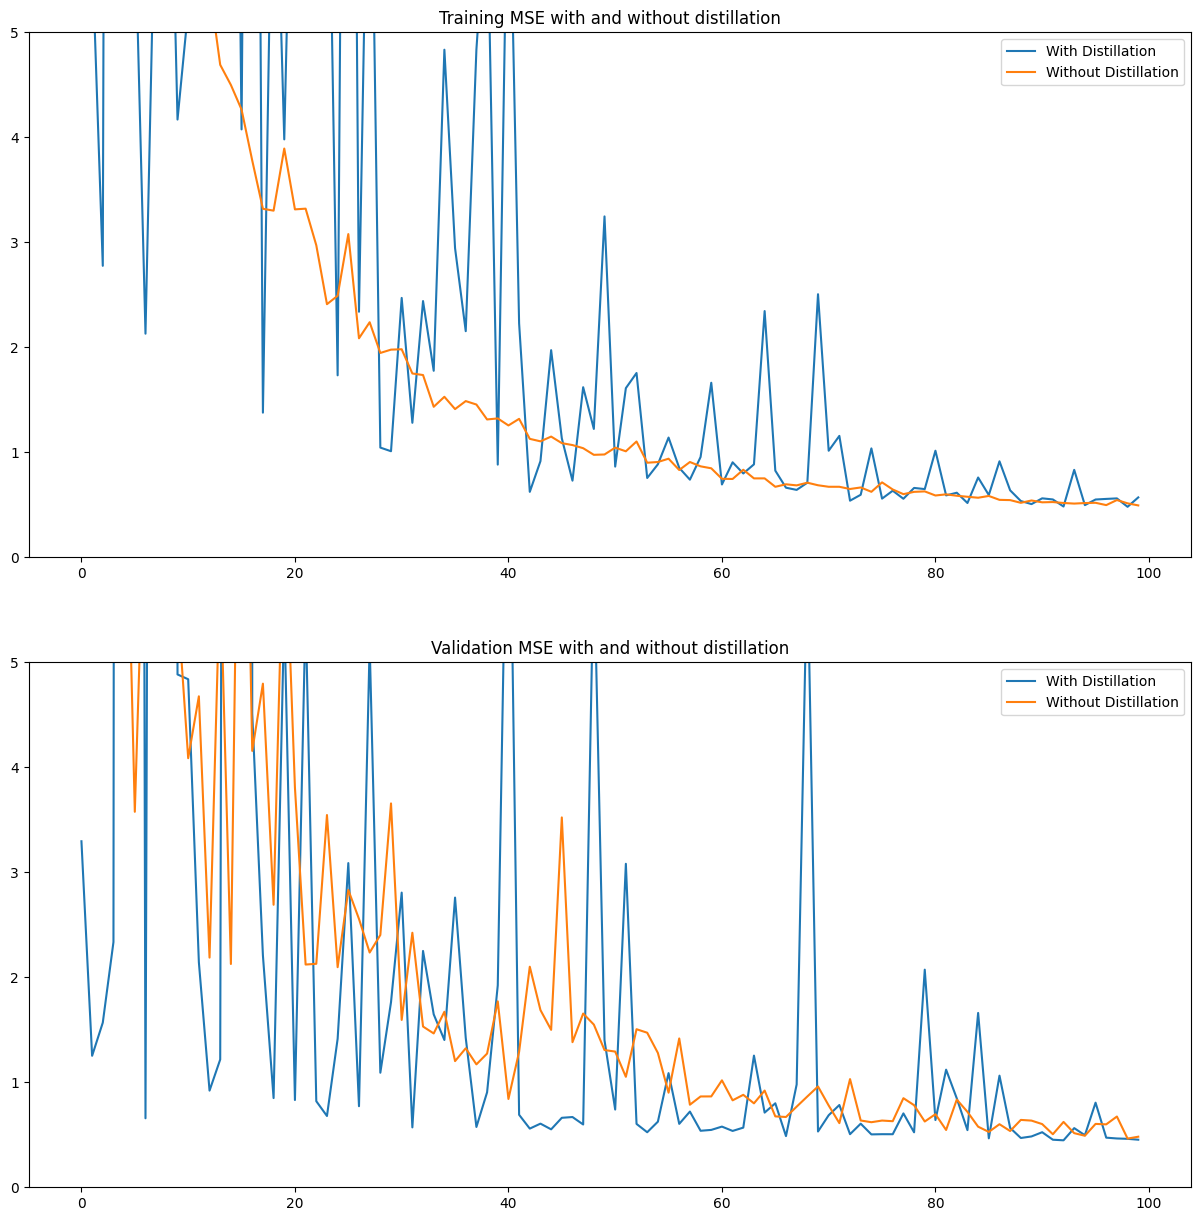

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['mse'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_mse'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_mse'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training MSE with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation MSE with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")
#print(f"Test mse with disstillation {test_results_with_distillation}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")
#print(f"Test mse without disstillation {test_results_without_distillation}")

Validation mse with distillation 0.4975 +- 0.1183
Validation mse without disstillation 0.5003 +- 0.0471


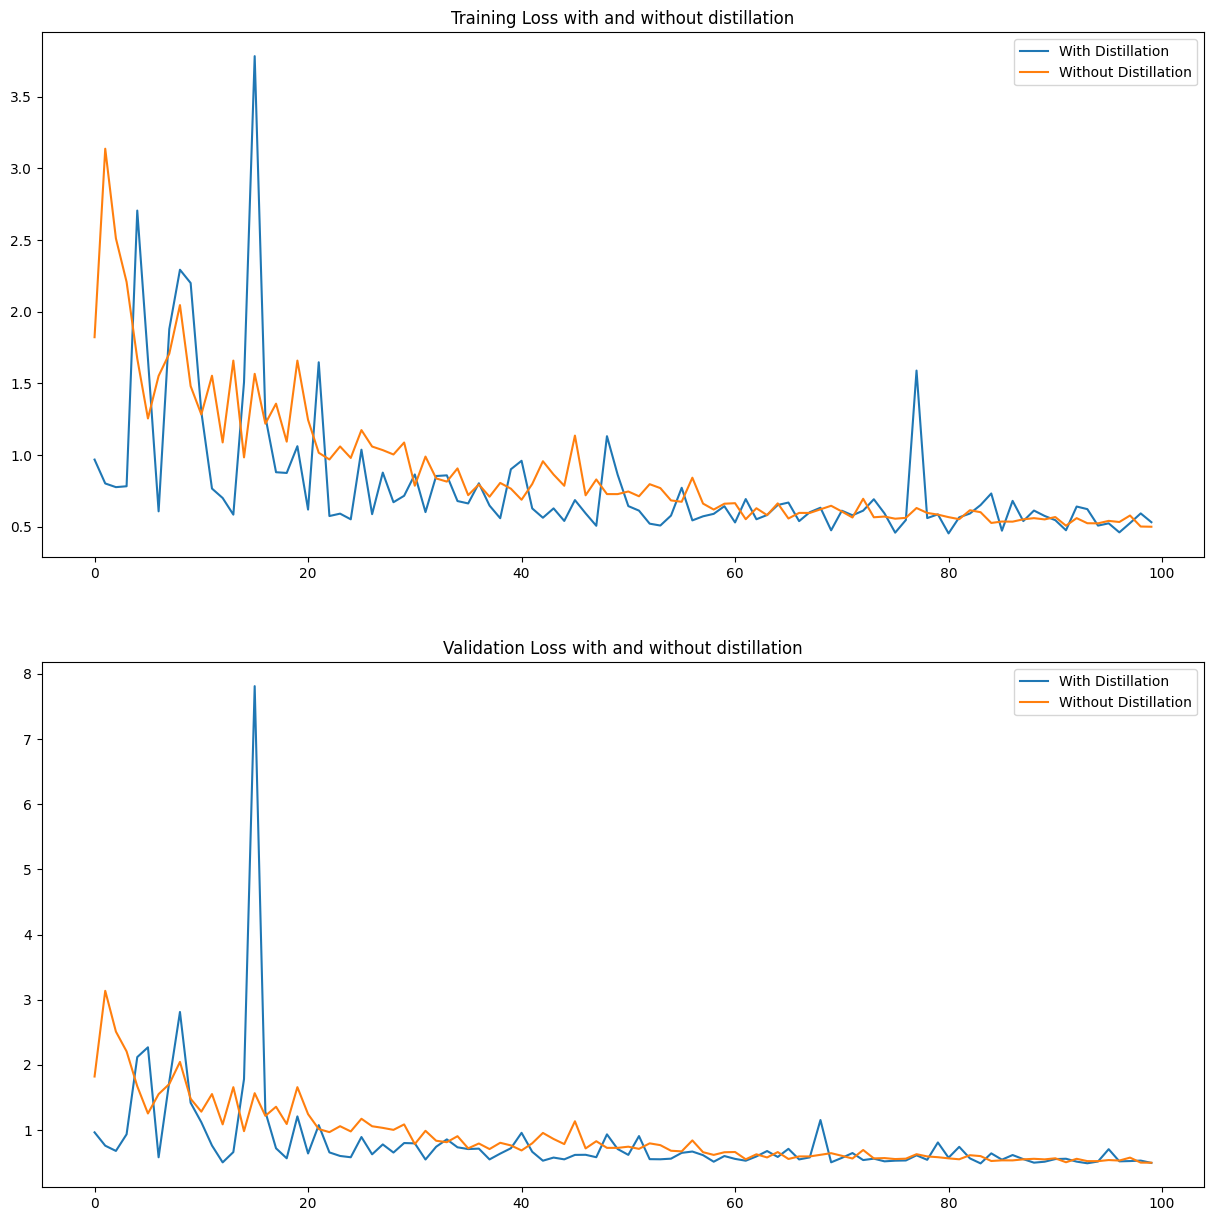

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['student_loss'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['student_loss'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['loss'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_student_loss'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_student_loss'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_loss'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
#axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training Loss with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
#axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation Loss with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")

In [13]:
# Train again on the entire traning set and then test
studnet_model = buildStudentModel()
studnet_model_without_distillation = keras.models.clone_model(studnet_model)

distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['mse', 'mae', 'mape'],
    student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
    distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
    alpha=0.1,
    temperature=10        
)
# Retrain both models
distiller.fit(x_train, y_train, epochs=number_of_epochs)

studnet_model_without_distillation.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=['mse', 'mae', 'mape'],
)
studnet_model_without_distillation.fit(x_train, y_train, epochs=number_of_epochs)
    
# Evaluate the models onb the test data when the training is complete    
# Evaluate student on test dataset
test_results_with_distillation = distiller.evaluate(x_test, y_test, return_dict=True)
test_results_without_distillation = studnet_model_without_distillation.evaluate(x_test, y_test, return_dict=True)

Epoch 1/100
492/492 [==============================] - 1s 2ms/step - mse: 54.7554 - mae: 2.0341 - mape: 139.8412 - student_loss: 2.0293 - distillation_loss: 54.2274
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - mse: 0.8999 - mae: 0.7108 - mape: 49.1247 - student_loss: 0.7103 - distillation_loss: 0.4554
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - mse: 1.0025 - mae: 0.7007 - mape: 47.1669 - student_loss: 0.7002 - distillation_loss: 0.5715
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - mse: 1.4799 - mae: 0.8025 - mape: 53.6476 - student_loss: 0.8016 - distillation_loss: 1.0541
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9397 - mae: 0.6890 - mape: 45.5210 - student_loss: 0.6888 - distillation_loss: 0.5188
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - mse: 1.5526 - mae: 0.8575 - mape: 57.3711 - student_loss: 0.8574 - distillation_loss: 1.1339
Epoch 7/100
492/492 [====

492/492 [==============================] - 1s 2ms/step - mse: 0.6226 - mae: 0.5852 - mape: 37.8159 - student_loss: 0.5853 - distillation_loss: 0.2101
Epoch 52/100
492/492 [==============================] - 1s 2ms/step - mse: 0.8437 - mae: 0.6194 - mape: 40.4238 - student_loss: 0.6184 - distillation_loss: 0.4141
Epoch 53/100
492/492 [==============================] - 1s 2ms/step - mse: 0.5578 - mae: 0.5571 - mape: 35.8527 - student_loss: 0.5577 - distillation_loss: 0.1402
Epoch 54/100
492/492 [==============================] - 1s 2ms/step - mse: 0.5733 - mae: 0.5693 - mape: 36.7276 - student_loss: 0.5688 - distillation_loss: 0.1657
Epoch 55/100
492/492 [==============================] - 1s 2ms/step - mse: 0.5387 - mae: 0.5556 - mape: 35.4748 - student_loss: 0.5560 - distillation_loss: 0.1264
Epoch 56/100
492/492 [==============================] - 1s 2ms/step - mse: 0.5972 - mae: 0.5683 - mape: 36.6365 - student_loss: 0.5695 - distillation_loss: 0.1851
Epoch 57/100
492/492 [=============

492/492 [==============================] - 1s 2ms/step - loss: 5.3478 - mse: 259.1340 - mae: 5.3478 - mape: 357.1506
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - loss: 3.1371 - mse: 24.8275 - mae: 3.1371 - mape: 210.3923
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - loss: 2.8782 - mse: 24.5952 - mae: 2.8782 - mape: 191.7099
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - loss: 2.7221 - mse: 17.8931 - mae: 2.7221 - mape: 180.4138
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - loss: 2.2966 - mse: 12.2444 - mae: 2.2966 - mape: 151.7617
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - loss: 1.9483 - mse: 9.2650 - mae: 1.9483 - mape: 129.2506
Epoch 7/100
492/492 [==============================] - 1s 2ms/step - loss: 2.4523 - mse: 18.3312 - mae: 2.4523 - mape: 161.9798
Epoch 8/100
492/492 [==============================] - 1s 2ms/step - loss: 1.8678 - mse: 9.7621 - mae: 1.8678 - mape

492/492 [==============================] - 1s 2ms/step - loss: 0.7034 - mse: 1.0386 - mae: 0.7034 - mape: 44.1484
Epoch 66/100
492/492 [==============================] - 1s 2ms/step - loss: 0.5958 - mse: 0.7089 - mae: 0.5958 - mape: 36.8384
Epoch 67/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6343 - mse: 1.1424 - mae: 0.6343 - mape: 39.8958
Epoch 68/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6256 - mse: 0.7389 - mae: 0.6256 - mape: 39.1474
Epoch 69/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6665 - mse: 0.9299 - mae: 0.6665 - mape: 42.1776
Epoch 70/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6018 - mse: 0.7496 - mae: 0.6018 - mape: 37.5273
Epoch 71/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6105 - mse: 0.8241 - mae: 0.6105 - mape: 37.9797
Epoch 72/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6498 - mse: 0.8224 - mae: 0.6498 - mape: 40.75

In [14]:
print(f"Test mse with disstillation {test_results_with_distillation}")
print(f"Test mse without disstillation {test_results_without_distillation}")

Test mse with disstillation {'mse': 0.5488108396530151, 'mae': 0.5647621154785156, 'mape': 37.56532669067383, 'student_loss': 0.5858384370803833}
Test mse without disstillation {'loss': 0.5260236859321594, 'mse': 0.5857128500938416, 'mae': 0.5260236859321594, 'mape': 28.14897918701172}


In [22]:
# # Save the model to load in future
# %mkdir Exp1Models
#%mkdir Exp1Models/Exp2

# studnet_model.save('Exp1Models/Exp2/studnet_model')
# studnet_model_without_distillation.save('Exp1Models/Exp2/studnet_model_without_distillation')

The syntax of the command is incorrect.


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets
